In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Detected Sampling Frequency: 8.62 Hz
Variance Window: 25 samples (3s)
Threshold Window: 86 samples (10.0s)


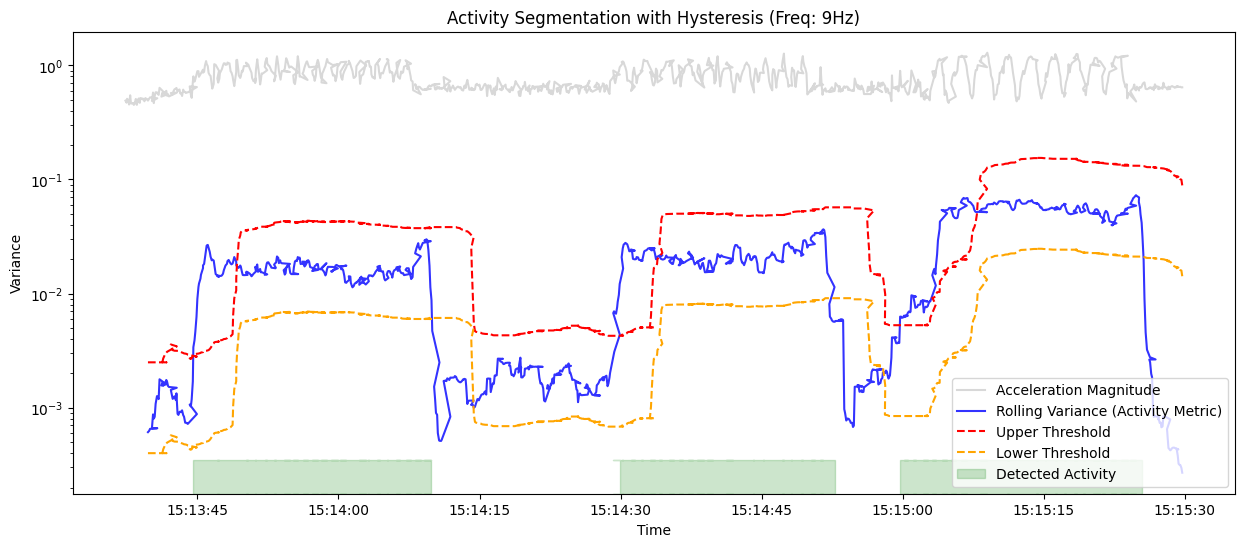

Segmented data saved to ../data/processed/segmented_data.csv


In [48]:
# Load the processed data
data_path = '../data/processed/cleaned_data.csv'
df = pd.read_csv(data_path)

# Ensure 'time' column is parsed as datetime and set as index
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# Calculate the magnitude of acceleration
df['Acc_Magnitude'] = np.sqrt(df['AccX(g)']**2 + df['AccY(g)']**2 + df['AccZ(g)']**2)

# --- IMPROVED SEGMENTATION LOGIC WITH HYSTERESIS ---

# 1. Calculate Sampling Frequency
time_diff = (df.index[1] - df.index[0]).total_seconds()
sampling_freq = 1 / time_diff
print(f"Detected Sampling Frequency: {sampling_freq:.2f} Hz")

# 2. Define Window Sizes in Seconds
variance_window_sec = 3   # Short window to detect immediate movement
threshold_window_sec = 10.0 # Long window to establish a baseline context

variance_window = int(variance_window_sec * sampling_freq)
threshold_window = int(threshold_window_sec * sampling_freq)

print(f"Variance Window: {variance_window} samples ({variance_window_sec}s)")
print(f"Threshold Window: {threshold_window} samples ({threshold_window_sec}s)")

# 3. Compute Rolling Variance (Activity Metric)
df['Rolling_Variance'] = df['Acc_Magnitude'].rolling(window=variance_window).var()

# 4. Dynamic Thresholding with Hysteresis
# We use a longer window to find the 'background' level. 
# We also add a minimum floor to ignore pure sensor noise.
noise_floor = 0.001 # Minimum variance to be considered activity (adjust based on sensor noise)
percentile = 50     # Median of the rolling variance over the long window

df['Dynamic_Threshold'] = df['Rolling_Variance'].rolling(window=threshold_window, min_periods=1).quantile(0.5)
df['Final_Threshold_Upper'] = df['Dynamic_Threshold'].clip(lower=noise_floor) * 2.5 # Upper threshold

df['Final_Threshold_Lower'] = df['Dynamic_Threshold'].clip(lower=noise_floor) * 0.4 # Lower threshold

# 5. Label Activity with Hysteresis
active = False
activity_labels = []

for variance, upper, lower in zip(df['Rolling_Variance'], df['Final_Threshold_Upper'], df['Final_Threshold_Lower']):
    if active:
        if variance < lower:
            active = False
    else:
        if variance > upper:
            active = True
    activity_labels.append(active)

df['Activity_Label'] = activity_labels

# Plot the results
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Acc_Magnitude'], label='Acceleration Magnitude', alpha=0.3, color='gray')
plt.plot(df.index, df['Rolling_Variance'], label='Rolling Variance (Activity Metric)', alpha=0.8, color='blue')
plt.plot(df.index, df['Final_Threshold_Upper'], label='Upper Threshold', linestyle='--', color='red')
plt.plot(df.index, df['Final_Threshold_Lower'], label='Lower Threshold', linestyle='--', color='orange')
plt.fill_between(df.index, 0, df['Rolling_Variance'].max(), where=df['Activity_Label'], color='green', alpha=0.2, transform=plt.gca().get_xaxis_transform(), label='Detected Activity')
plt.legend()
plt.title(f'Activity Segmentation with Hysteresis (Freq: {sampling_freq:.0f}Hz)')
plt.xlabel('Time')
plt.ylabel('Variance')
plt.yscale('log') # Log scale often helps visualize variance better
plt.show()

# Save the segmented data
segmented_data_path = '../data/processed/segmented_data.csv'
df.to_csv(segmented_data_path)
print(f"Segmented data saved to {segmented_data_path}")

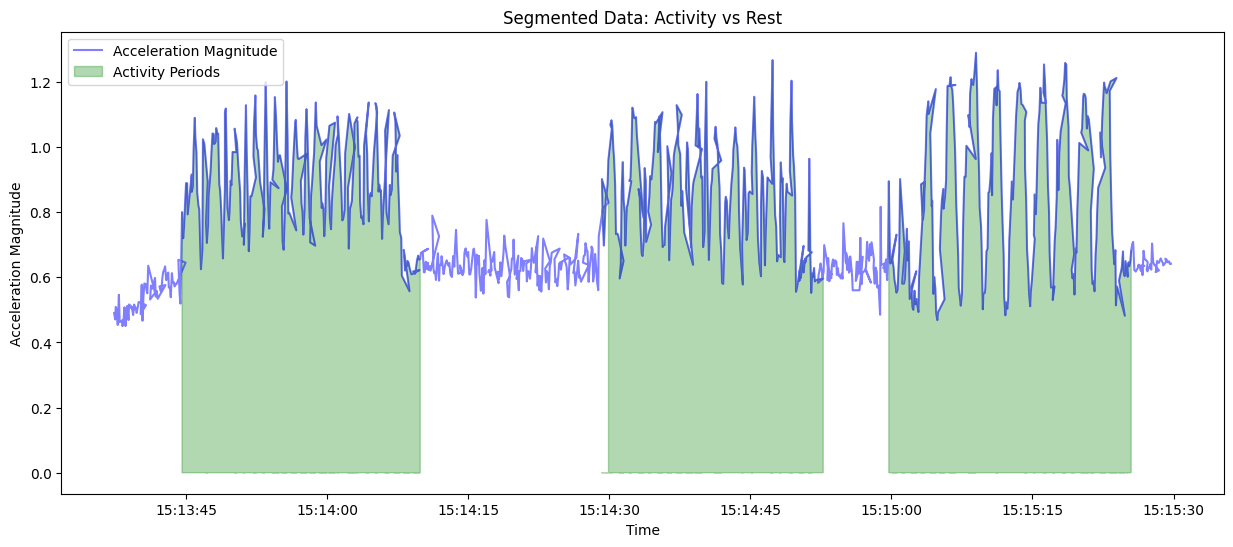

In [49]:
# Visualize Segmented Data
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Acc_Magnitude'], label='Acceleration Magnitude', alpha=0.5, color='blue')
plt.fill_between(df.index, 0, df['Acc_Magnitude'], where=df['Activity_Label'], color='green', alpha=0.3, label='Activity Periods')
plt.title('Segmented Data: Activity vs Rest')
plt.xlabel('Time')
plt.ylabel('Acceleration Magnitude')
plt.legend()
plt.show()

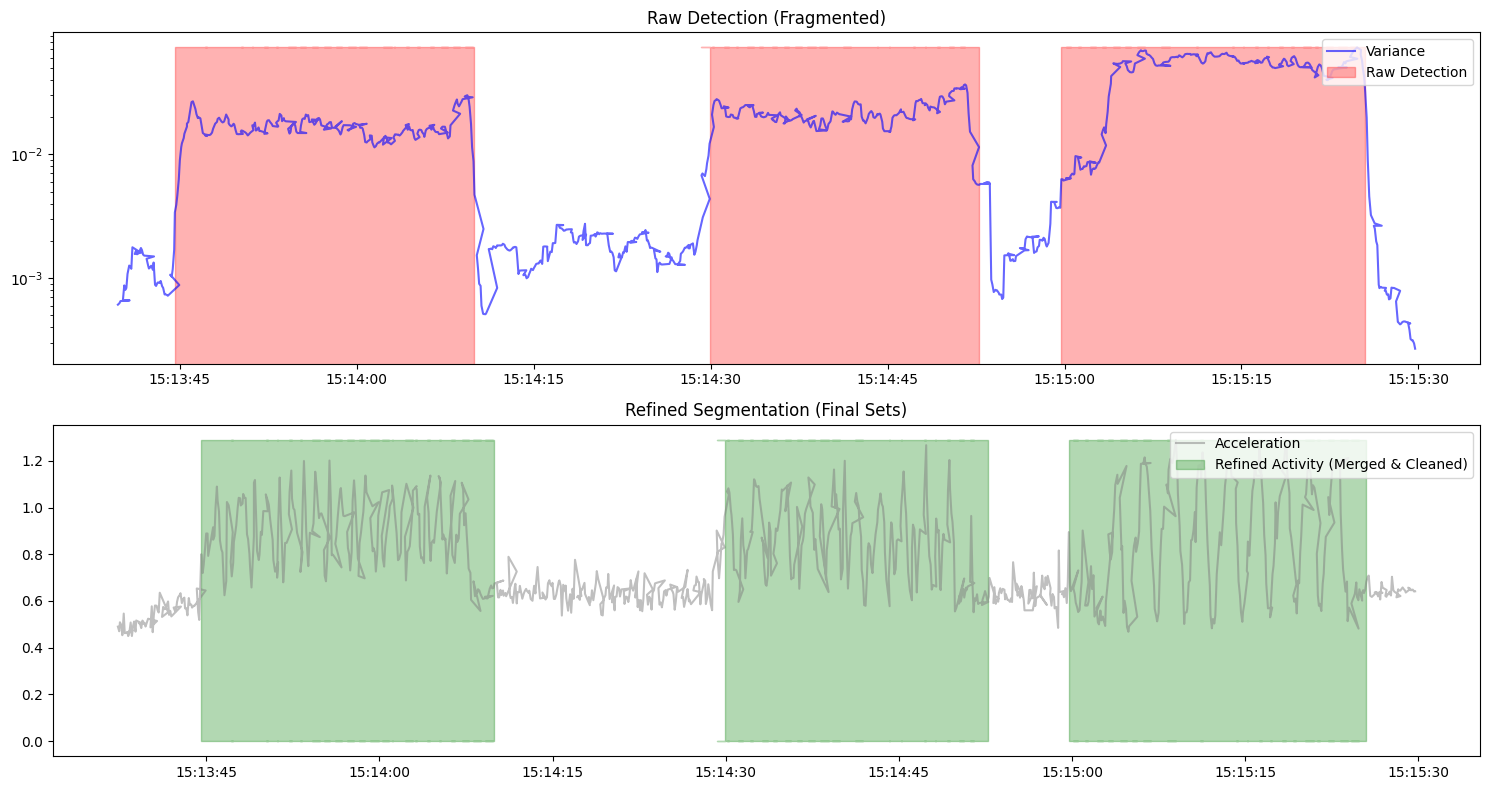

Refined segmentation saved.


In [ ]:
# --- POST-PROCESSING: REFINE LABELS ---

def refine_activity_labels(series, min_duration_sec, min_gap_sec, freq):
    """
    Refines binary activity labels by:
    1. Merging activities separated by short gaps (min_gap_sec).
    2. Removing activities shorter than a minimum duration (min_duration_sec).
    """
    labels = series.copy()
    
    # Convert seconds to samples
    min_gap_samples = int(min_gap_sec * freq)
    min_duration_samples = int(min_duration_sec * freq)
    
    # 1. Merge small gaps (Fill short 'False' periods with 'True')
    # Identify continuous blocks
    changes = labels.ne(labels.shift()).cumsum()
    counts = labels.groupby(changes).transform('count')
    
    # If label is False (Rest) and duration < min_gap, switch to True (Active)
    mask_gaps = (~labels) & (counts < min_gap_samples)
    labels[mask_gaps] = True
    
    # 2. Remove short activities (Fill short 'True' periods with 'False')
    # Re-calculate blocks after merging
    changes = labels.ne(labels.shift()).cumsum()
    counts = labels.groupby(changes).transform('count')
    
    # If label is True (Active) and duration < min_duration, switch to False (Rest)
    mask_short = (labels) & (counts < min_duration_samples)
    labels[mask_short] = False
    
    return labels

# Apply Refinement
# - Merge gaps < 2.0 seconds (e.g., pausing at the top of a rep)
# - Ignore sets < 3.0 seconds (too short to be a real exercise)
df['Refined_Activity_Label'] = refine_activity_labels(
    df['Activity_Label'], 
    min_duration_sec=3.0, 
    min_gap_sec=2.0, 
    freq=sampling_freq
)

# Visualize Comparison
plt.figure(figsize=(15, 8))

# Plot 1: Raw Variance & Thresholds
plt.subplot(2, 1, 1)
plt.plot(df.index, df['Rolling_Variance'], label='Variance', color='blue', alpha=0.6)
plt.fill_between(df.index, 0, df['Rolling_Variance'].max(), where=df['Activity_Label'], color='red', alpha=0.3, label='Raw Detection')
plt.title('Raw Detection (Fragmented)')
plt.yscale('log')
plt.legend(loc='upper right')

# Plot 2: Refined Activity
plt.subplot(2, 1, 2)
plt.plot(df.index, df['Acc_Magnitude'], label='Acceleration', color='gray', alpha=0.5)
plt.fill_between(df.index, 0, df['Acc_Magnitude'].max(), where=df['Refined_Activity_Label'], color='green', alpha=0.3, label='Refined Activity (Merged & Cleaned)')
plt.title('Refined Segmentation (Final Sets)')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [51]:
# Save the FINAL refined data
df.to_csv(segmented_data_path)
print("Refined segmentation saved.")

Refined segmentation saved.
